In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
data = pd.read_csv('turbocharger_final_faults.csv')
df = pd.DataFrame(data)

In [3]:
df.head()

,BoostPressure[PSI],CompressorSpeed[RPM],ExhaustTemperature[°C],OilPressure[PSI],AirMassFlow[g/s],EngineLoad[%],AmbientTemperature[°C],WastegatePosition[%],RPM[Engine],TurbochargerAge[Years],TurbochargerPerformance
0,14.328457,76546.05619,838.266715,45.383729,52.838488,52.565551,20.243342,74.435634,3437.844861,5.091366,97.151834
1,12.349446,56933.42785,616.650675,47.901231,33.855298,71.525571,17.983378,38.692665,3836.948611,4.333771,66.094402
2,15.824031,102274.67830,750.848913,43.138273,50.545572,55.608922,21.237841,39.890341,4704.068284,3.648982,90.958379
3,13.947464,75542.83908,729.195521,40.789358,44.934876,49.338395,18.168887,54.226550,2837.240548,7.282656,74.642433
4,16.630494,71497.64289,815.906057,35.017265,49.435867,48.855853,33.192392,74.791519,3489.229076,3.715595,99.978033


In [4]:
df.tail()

,BoostPressure[PSI],CompressorSpeed[RPM],ExhaustTemperature[°C],OilPressure[PSI],AirMassFlow[g/s],EngineLoad[%],AmbientTemperature[°C],WastegatePosition[%],RPM[Engine],TurbochargerAge[Years],TurbochargerPerformance
219995,11.127715,96805.10837,595.245598,33.629821,28.538705,73.749391,6.960582,23.184061,3505.332776,6.279077,54.251402
219996,11.939668,84683.61256,658.801373,43.731396,40.574358,44.433646,24.336183,59.156179,4429.794859,3.783215,80.243106
219997,13.314496,80121.63293,647.457895,40.350770,33.239654,43.958276,17.674958,40.709131,4680.423088,5.995170,68.704067
219998,13.041929,66934.91439,717.146273,36.351496,42.233164,56.706731,26.848311,48.330434,4198.337745,1.824159,93.297079
219999,9.625794,91184.25151,603.230723,43.268801,30.840908,72.479261,0.470172,30.104715,4196.692454,6.268642,51.887264


In [5]:
df.shape

(220000, 11)

In [6]:
df.isnull().sum()

BoostPressure[PSI]         0
CompressorSpeed[RPM]       0
ExhaustTemperature[°C]     0
OilPressure[PSI]           0
AirMassFlow[g/s]           0
EngineLoad[%]              0
AmbientTemperature[°C]     0
WastegatePosition[%]       0
RPM[Engine]                0
TurbochargerAge[Years]     0
TurbochargerPerformance    0
dtype: int64

In [7]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [8]:
X = pd.DataFrame(X)

In [9]:
corr_matrix = X.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
drop_cols = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
X = X.drop(columns=drop_cols)

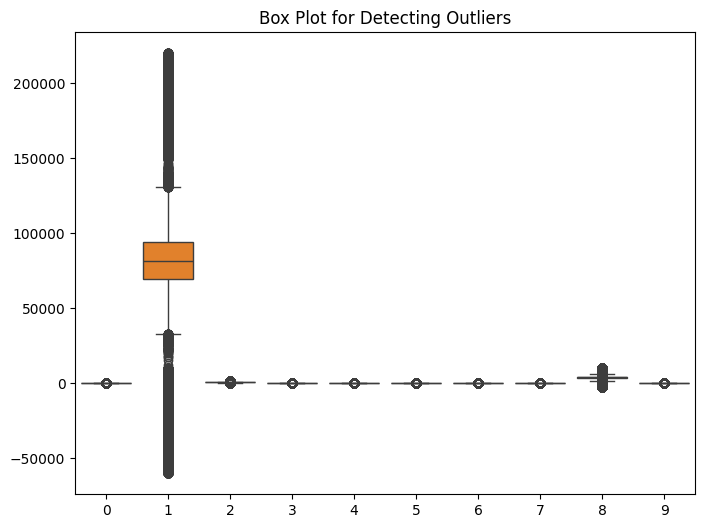

In [10]:
plt.figure(figsize=(8,6))
sns.boxplot(data=X)
plt.title('Box Plot for Detecting Outliers')
plt.show()

In [11]:
Q1 = np.percentile(X, 25, axis = 0)
Q3 = np.percentile(X, 75, axis = 0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
mask = (X >= lower_bound) & (X <= upper_bound)
filtered_indices = np.all(mask, axis=1)

X_filtered = X[filtered_indices]
y_filtered = y[filtered_indices]

print('Outliers removed. New Dataset shape: ', X_filtered.shape)

Outliers removed. New Dataset shape:  (197554, 10)


In [12]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_filtered)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_filtered, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
xgb_model = XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=500, 
    learning_rate=0.05, 
    max_depth=6, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [15]:
y_pred = xgb_model.predict(X_test)

In [16]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error (MSE): ', mse)
print('Mean Absolute Error (MAE): ', mae)
print('R-Squared (R2): ', r2)

Mean Squared Error (MSE):  15.269349533298119
Mean Absolute Error (MAE):  3.0930381140190644
R-Squared (R2):  0.9259764708646108


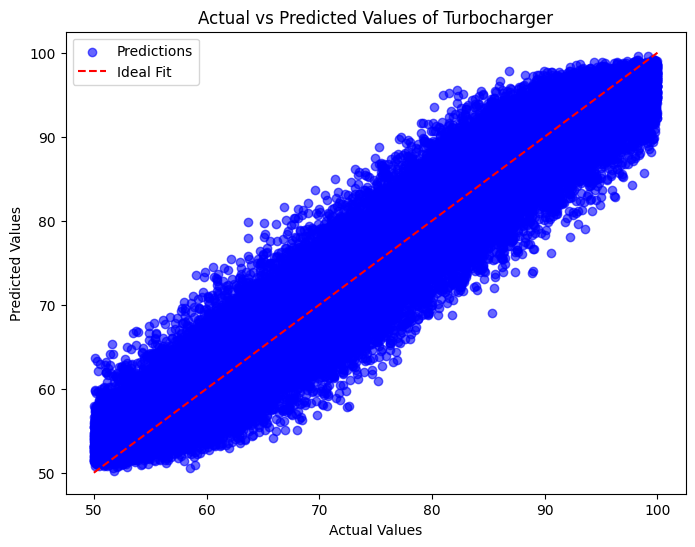

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color = 'blue', alpha = 0.6, label = 'Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red', linestyle = '--', label = 'Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values of Turbocharger')
plt.legend()
plt.show()